# Package

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import optimizer
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.models as models
import csv
import os
import cv2
import torchvision.transforms as transforms
import pandas as pd
import time


c:\Users\pces1\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def readfile(path, label):
    true_list = []
    # label 是一个 boolean variable, 代表需不需要回传 y 值
    image_dir = sorted(os.listdir(path))  # os.listdir(path)将path路径下的文件名以列表形式读出
    # print(os.listdir(path))
    # print(image_dir)
    x = np.zeros((len(image_dir), 256, 256, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))  # os.path.join(path, file) 路径名合并
        # print(img.shape)
        x[i, :, :] = cv2.resize(img, (256, 256))
        if label:
            y[i] = int(file.split("_")[0])
            
    if label:
        return x, y
    else:
        return x


# 分别将 training set、validation set、testing set 用 readfile 函式读进来
workspace_dir = './Face Mask Dataset'
print("Reading data")
print("...")
train_x, train_y = readfile(os.path.join(workspace_dir, "testingTrain"), True)
print("Size of training data = {}".format(len(train_x)))
# val_x, val_y = readfile(os.path.join(workspace_dir, "valid set"), True)
# print("Size of validation data = {}".format(len(val_x)))
test_x, test_y = readfile(os.path.join(workspace_dir, "testingTest"), True)
print("Size of Testing data = {}".format(len(test_x)))
# print("Reading data complicated")

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomCrop(224),
    transforms.ToTensor(),
])

valid_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])


Reading data
...
Size of training data = 1000
Size of Testing data = 1992


In [3]:
def random_seed_setup(seed):
    # For reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        print("device: cuda")
        return 'cuda'
    else:
        print("device: cpu")
        return 'cpu'
device = random_seed_setup(42096)

class ExampleDataset(Dataset):

    # data loading
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:  # 如果没有标签那么只返回X
            return X



train_set = ExampleDataset(train_x, train_y, train_transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
# valid_set = ExampleDataset(val_x, val_y, valid_transform)
# valid_dataloader = DataLoader(valid_set, batch_size=1)

device: cpu


# Normalization

In [31]:
# mean = dataset.x.data.mean(dim=0).unsqueeze(0)
# std = dataset.x.data.std(dim=0).unsqueeze(0)
# dataset.x = (dataset.x - dataset.x.data.mean(dim=0).unsqueeze(0)) / dataset.x.data.std(dim=0).unsqueeze(0)
# print(dataset.x)
# print(dataset.y)

# Build model

In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 模型參考至 https://reurl.cc/4XGe9V
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 256, 256]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),  # [64, 128, 128]

            nn.Conv2d(64, 128, 3, 1, 1),  # [128, 128, 128]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),  # [128, 64, 64]

            nn.Conv2d(128, 256, 3, 1, 1),  # [256,  64, 64]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),  # [256, 32, 32]

            nn.Conv2d(256, 512, 3, 1, 1),  # [512, 32, 32]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),  # [512, 16, 16]

            nn.Conv2d(512, 512, 3, 1, 1),  # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),  # [512, 8, 8]
        )
        self.fc = nn.Sequential(
            nn.Linear(512 * 8 * 8, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

model = ConvNet()
model.to(device)
FILE = 'model_state_dict3.pt'

# Fit dataset

Epoch 1
-------------------------------
loss: 11.709886  [  288/ 1000]
loss: 2.186192  [  608/ 1000]
loss: 0.623267  [  928/ 1000]
Epoch 2
-------------------------------
loss: 0.450961  [  288/ 1000]
loss: 0.385425  [  608/ 1000]
loss: 0.298457  [  928/ 1000]
Epoch 3
-------------------------------
loss: 0.315861  [  288/ 1000]
loss: 0.345844  [  608/ 1000]
loss: 0.247658  [  928/ 1000]
Epoch 4
-------------------------------
loss: 0.286576  [  288/ 1000]
loss: 0.238824  [  608/ 1000]
loss: 0.204762  [  928/ 1000]
Epoch 5
-------------------------------
loss: 0.140032  [  288/ 1000]
loss: 0.175137  [  608/ 1000]
loss: 0.195783  [  928/ 1000]
Epoch 6
-------------------------------
loss: 0.115264  [  288/ 1000]
loss: 0.176562  [  608/ 1000]
loss: 0.135495  [  928/ 1000]
Epoch 7
-------------------------------
loss: 0.115151  [  288/ 1000]
loss: 0.092907  [  608/ 1000]
loss: 0.112341  [  928/ 1000]
Epoch 8
-------------------------------
loss: 0.137229  [  288/ 1000]
loss: 0.134343  [  

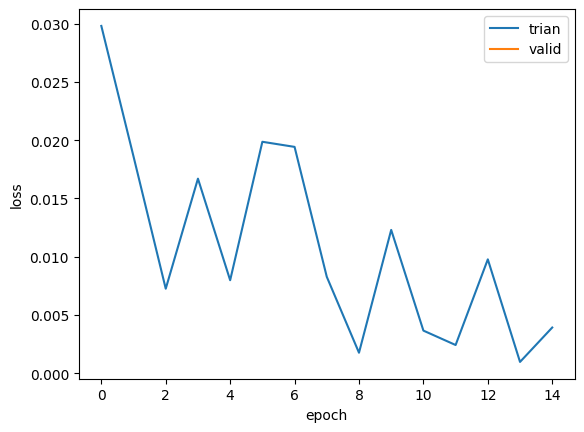

In [5]:
criterion = nn.CrossEntropyLoss()  # loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) 
model.train()
alist = []
blist = []
def train_loop(dataloader, model, criterion, optimizer, train_graph):
    total = 0
    valid_loss = 0
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        # print("pred" + str(pred))
        # print("y" + str(y))
        loss = criterion(pred, y)
        # print(loss)
        total += loss.item()
        
        # Backpropagation
        # loss = loss.to(torch.float32)
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        alist.append(total)
        if (batch+1) % 10 == 0:
            current = batch * len(X)
            print(f"loss: {total/10:>7f}  [{current:>5d}/{size:>5d}]")
            total = 0
            torch.save({'model_state_dict': model.state_dict()}, FILE)
    total_loss = total / len(dataloader)
    train_graph.append(total_loss)
    # # scheduler.step()
    # with torch.no_grad():
    #     for x, y in valid_dataloader:
    #         x, y = x.to(device), y.to(device)
    #         y_pred = model(x)
    #         loss = criterion(y_pred, y)
    #         valid_loss += loss.item()
            
    #     valid_loss_value = valid_loss / len(valid_dataloader)
    #     valid_graph.append(valid_loss_value)
            
epochs = 15
train_graph = []
valid_graph = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, criterion, optimizer, train_graph)
    blist.append(t)
# torch.save({'model_state_dict': model.state_dict()}, FILE)


plt.plot(train_graph, label='train_loss')
plt.plot(valid_graph, label='valid_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['trian', 'valid'], loc='upper right')

# Re-load best weight, and prediction test dataset

In [8]:
checkpoint = torch.load(FILE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

test_set = ExampleDataset(test_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)


# dataset2.x = (dataset2.x - mean) / std
# print(dataset2.x)


# save test prediction, and plot figure

In [9]:
clist = []
dlist = []
pred_value = []
true_value = []
difference_id = []
for batch, X in enumerate(test_loader):
      X = X.to(device)
      pred = model(X)
      # print(y)
      test_label = np.argmax(pred.cpu().data.numpy(), axis=1)
      # print(pred)
      clist.append(test_label)

for i in range(len(test_loader)):
  pred_value.append(clist[i][0])
# print(pred_value)

for i in range(len(test_y)):
  true_value.append(test_y[i])

for i in range(len(test_loader)):
  if pred_value[i] != true_value[i]:
      difference_id.append(i)

print(difference_id)


# print(true_value)
# print(alist)
# for i in range(len(alist)):
#   # if ((i+1) % 35) ==0 :
#     dlist.append(alist[i]/10)
# print(dlist)

# for i in range(epochs * 35):
#   elist.append(i)


# predicted = model(dataset2.x).detach().numpy()




# plt.plot(elist,dlist)
# plt.xlabel('Training steps')
# plt.ylabel('MSE loss')
# plt.show()

[10, 22, 23, 25, 26, 27, 28, 29, 31, 43, 44, 48, 49, 50, 64, 71, 81, 91, 99, 108, 128, 134, 135, 145, 151, 164, 194, 203, 204, 205, 206, 212, 215, 217, 224, 227, 235, 245, 246, 251, 255, 262, 267, 281, 289, 299, 303, 313, 316, 324, 330, 337, 346, 347, 363, 370, 374, 376, 377, 379, 392, 401, 403, 406, 407, 408, 411, 420, 421, 424, 426, 435, 441, 444, 445, 446, 452, 456, 459, 461, 467, 469, 472, 478, 485, 489, 499, 504, 508, 510, 518, 520, 524, 534, 535, 538, 540, 546, 574, 575, 591, 600, 604, 613, 618, 621, 625, 634, 636, 645, 649, 652, 665, 673, 675, 682, 687, 689, 696, 744, 758, 760, 763, 769, 770, 771, 772, 773, 781, 782, 784, 785, 786, 787, 822, 828, 829, 830, 831, 832, 834, 836, 837, 839, 850, 851, 852, 853, 854, 887, 893, 941, 942, 943, 945, 946, 947, 948, 949, 950, 952, 953, 954, 956, 957, 1057, 1118, 1131, 1197, 1254, 1331, 1385, 1429, 1472, 1506, 1583, 1624]


# Upload Format

In [10]:
tp = 0
tn = 0
fp = 0
fn = 0

for i in range(len(test_y)):
    if pred_value[i] == 0 and true_value[i] == 0:
        tp += 1
    elif pred_value[i] == 1 and true_value[i] == 1:
        tn += 1
    elif pred_value[i] == 1 and true_value[i] == 0:
        fp += 1
    else:
        fn += 1

print(tp, fp)
print(fn, tn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
print(recall)
print(precision)
score = 2 * recall * precision / (precision + recall)

print(score)

818 165
12 997
0.9855421686746988
0.832146490335707
0.9023717595146166
